# Page Rank-Power Iteration Method

In this notebook, we're exploring the power iteration method, a key technique in numerical linear algebra used to find the dominant eigenvector of an adjacency matrix. This method is crucial for various computational tasks, including the PageRank algorithm. Developed by Larry Page and Sergey Brin, PageRank revolutionized web search engines by ranking web pages based on their importance and relevance. By iteratively applying the power iteration method to the web's connectivity structure, PageRank determines a page's significance within the vast web ecosystem. It's a fundamental concept that has profoundly influenced how we navigate and retrieve information online.

In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using CSV
using DataFrames
using MAT

Let's start by creating a struct for the "Web" matrix. The adjacency matrix, shows outgoing and ingoing links from one webpage to another. Let $M$ be the adjacency matrix where $M_{ij}=1$ if two webpages are connected, and  $M_{ij}=0$ if they are not. The adjacency matrix, by default is going to be extremely sparse so we want to keep all our components in a struct (also mutable in order to be able to pass it in functions by reference) rather than creating the full matrix.

In [2]:
mutable struct Google
    adjency_matrix::SparseMatrixCSC{Float64, Int64}                        
    e::Vector{Float64}                      
    n::Int64                              
end

In [3]:
df=CSV.read("google.csv",DataFrame;header=false)

500×500 DataFrame
 Row │ Column1  Column2  Column3  Column4  Column5  Column6  Column7  Column8  ⋯
     │ Int64    Int64    Int64    Int64    Int64    Int64    Int64    Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       1        0        0        0        0        0        0        0  ⋯
   2 │       1        1        0        0        0        1        1        0
   3 │       1        0        0        0        0        0        0        0
   4 │       0        1        0        0        0        1        1        1
   5 │       0        1        0        0        0        0        0        0  ⋯
   6 │       0        1        0        0        0        1        0        1
   7 │       0        1        0        0        0        0        1        0
   8 │       0        1        0        0        0        0        1        1
  ⋮  │    ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮     ⋱
 494 │       0        0        0        0        0        0        0        0  ⋯
 495 │       0        0        0        0        0        0        0        0
 496 │       0        0        0        0        0        0        0        0
 497 │       0        0        0        0        0        0        0        0
 498 │       0        0        0        0        0        0        0        0  ⋯
 499 │       0        0        0        0        0        0        0        0
 500 │       0        0        0        0        0        0        0        0
                                                492 columns and 485 rows omitted

In [4]:
P=sparse(convert(Matrix{Float64}, Matrix(df)))

500×500 SparseMatrixCSC{Float64, Int64} with 12654 stored entries:
⎡⣿⣿⣟⣿⣿⣻⣟⣿⣟⣿⣟⣿⣿⣿⣿⣿⣿⢹⡟⢿⣿⡯⣿⣿⣿⣿⣿⡇⣯⣟⣏⣿⣿⣿⣿⣿⢿⣇⢸⢻⎤
⎢⣿⣯⡵⣽⣿⢭⢉⠍⡭⠭⠭⢹⠭⣿⣿⣽⡭⠨⠁⢸⣿⣧⣭⢭⠬⢭⠭⠅⡥⠥⡭⣭⢩⡯⢹⡯⢭⡍⢨⠌⎥
⎢⣿⡏⡇⣿⣿⢼⠂⡑⡇⣦⢥⢼⢆⣿⣿⣿⡗⠢⡀⢸⣿⡇⢼⣈⠐⢀⢨⡅⠁⠀⡇⠟⢠⣷⣸⣗⣺⡂⠘⠇⎥
⎢⣿⡷⡆⣸⣿⢰⡱⣦⡇⠀⠄⢹⡀⣿⣿⣾⡦⠀⡄⣸⣿⣇⣴⢠⠀⠀⣐⠂⠆⠀⡀⣒⠀⡇⢸⡇⢰⡄⢐⠀⎥
⎢⣿⣇⠇⣾⣿⠸⠀⠈⠷⣮⡅⢸⠄⣿⣿⢿⢧⢀⠀⢸⣿⡇⢄⡀⠠⠀⢀⠀⡆⠀⡀⣀⠀⣧⢸⡇⠼⠀⠀⠀⎥
⎢⣿⣟⡇⣹⣿⢸⣐⣃⡏⣡⡑⣼⣀⣿⣿⣿⣇⢀⡀⣸⣿⡇⣘⣀⢀⣀⣚⡃⡁⡀⡁⣛⣀⣇⣸⣇⢸⡈⢘⢁⎥
⎢⣿⢟⣃⡻⡿⠘⢛⡛⢃⠛⡁⢻⡛⣿⣿⠻⡛⠘⠃⠹⠿⠇⢛⠛⠙⡛⠛⡃⠃⠃⠃⠛⠛⠟⢻⢟⠘⠃⠘⡘⎥
⎢⢹⣨⡄⢁⡌⢠⠀⣀⡀⠀⠀⢠⠀⠀⠁⣄⣀⠀⠀⠠⡀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⢀⠀⠀⠀⎥
⎢⢸⢞⡗⣶⠖⠶⠒⡳⠖⡒⠒⠶⠒⢂⠀⡴⡵⢖⠔⠒⠖⡔⢶⡒⡲⠒⢂⡄⠖⠒⡖⣦⠐⠒⢒⡶⠶⠀⢠⢒⎥
⎢⠘⡆⠀⢃⡀⠃⠀⠁⠀⠃⠀⢠⠀⠀⠀⠀⠀⠀⠀⢄⠀⠀⠘⠁⠀⠀⠀⠀⠀⠀⠃⠀⠘⠃⠠⠈⠀⠀⠀⠀⎥
⎢⠀⡗⠅⣺⡇⠨⠈⠂⠅⠒⠀⢸⠂⠐⠚⠏⠇⠀⠄⠀⢿⢗⠐⠂⠀⠐⠐⠆⠄⠀⠒⠒⠀⠐⠸⠭⠬⠀⠐⠀⎥
⎢⠀⢸⠁⣿⣉⠊⠀⡇⠙⠯⠀⠀⠈⢸⠀⡃⡃⠀⠀⠀⠀⠁⣿⢟⠋⠰⢻⡇⠗⠐⡗⣿⠨⠅⠈⠀⠉⠁⢸⠁⎥
⎢⠀⢸⠂⢿⠒⠐⠀⡇⠂⠠⠀⠀⠐⢸⠂⠇⠇⠀⠀⠀⠀⠀⢹⠐⠓⢄⢸⡇⠧⠐⠗⣿⠐⠢⠀⠀⠐⠂⢸⠀⎥
⎢⠀⢸⠀⠋⠀⠀⠀⠁⠀⠒⠈⠀⠀⠨⠀⠁⠁⠀⠀⠀⠀⠀⠽⠂⠄⠀⠽⠅⠂⠀⠃⠋⠀⠐⠀⡤⠀⠀⠈⠀⎥
⎢⠀⢸⠀⠀⠀⠀⠈⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠑⢄⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢸⠀⠧⠀⠀⠀⠀⠀⢩⠀⠀⢅⠀⠀⠄⠄⠈⠀⠀⠩⠁⡍⢁⠤⠀⡬⠀⠀⠀⡕⢯⠈⠉⠀⠁⠀⠀⠠⠀⎥
⎢⠀⠈⡇⠀⣴⠀⠀⡄⠀⠀⠀⠀⢡⠀⠀⠀⠈⠈⠀⠀⠈⠀⠀⢰⠀⠀⠀⠀⠀⠁⠀⠁⢱⣎⡀⠈⠀⡆⠀⠀⎥
⎢⠀⠀⡇⣀⠉⢰⠀⠁⡆⠀⠀⠰⠈⠀⡀⡦⡆⠠⡄⠂⠆⡆⢀⠈⠀⠀⡀⡄⠀⠀⡄⣀⠈⠉⠱⣦⣴⠁⢀⠀⎥
⎢⠀⠀⡇⠆⠀⠘⠄⠦⠃⠀⠀⠠⠄⠀⠂⠣⠃⠀⠁⠀⠄⠁⠆⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠉⠙⢆⠀⠀⎥
⎣⠀⠀⠉⣆⡄⢀⣀⡀⠐⣀⠂⠀⡂⠀⠀⠀⢀⢀⠀⠀⢀⠀⢀⡀⣀⣀⣀⠀⠀⠀⣀⡂⡀⠀⡀⢀⠀⠀⠐⢆⎦

In order for the power iteration method to succeed we need two things from the matrix. Irreducibility and stochasticity. At the next cell we normalize our rows with the sum of the non-zero elements of the row.

In [5]:
function normalize(A::SparseMatrixCSC)
    nnz_per_row = zeros(Float64, size(A, 1))
    for col in 1:size(A, 2)
        for i in A.colptr[col]:(A.colptr[col + 1] - 1)
            row_index = A.rowval[i]
            nnz_per_row[row_index] += 1
        end
    end
    
    for col in 1:size(A, 2)
        for i in A.colptr[col]:(A.colptr[col + 1] - 1)
            row_index = A.rowval[i]
            if(nnz_per_row[row_index]!=0)
                A.nzval[i] *= nnz_per_row[row_index] ^ (-1)
            else
                row=fill(1/size(A,2),size(A,2))
                A[i,:]=row
            end
        end
    end
    
    return A
end

normalize (generic function with 1 method)

In [6]:
P=normalize(P)

500×500 SparseMatrixCSC{Float64, Int64} with 12654 stored entries:
⎡⣿⣿⣟⣿⣿⣻⣟⣿⣟⣿⣟⣿⣿⣿⣿⣿⣿⢹⡟⢿⣿⡯⣿⣿⣿⣿⣿⡇⣯⣟⣏⣿⣿⣿⣿⣿⢿⣇⢸⢻⎤
⎢⣿⣯⡵⣽⣿⢭⢉⠍⡭⠭⠭⢹⠭⣿⣿⣽⡭⠨⠁⢸⣿⣧⣭⢭⠬⢭⠭⠅⡥⠥⡭⣭⢩⡯⢹⡯⢭⡍⢨⠌⎥
⎢⣿⡏⡇⣿⣿⢼⠂⡑⡇⣦⢥⢼⢆⣿⣿⣿⡗⠢⡀⢸⣿⡇⢼⣈⠐⢀⢨⡅⠁⠀⡇⠟⢠⣷⣸⣗⣺⡂⠘⠇⎥
⎢⣿⡷⡆⣸⣿⢰⡱⣦⡇⠀⠄⢹⡀⣿⣿⣾⡦⠀⡄⣸⣿⣇⣴⢠⠀⠀⣐⠂⠆⠀⡀⣒⠀⡇⢸⡇⢰⡄⢐⠀⎥
⎢⣿⣇⠇⣾⣿⠸⠀⠈⠷⣮⡅⢸⠄⣿⣿⢿⢧⢀⠀⢸⣿⡇⢄⡀⠠⠀⢀⠀⡆⠀⡀⣀⠀⣧⢸⡇⠼⠀⠀⠀⎥
⎢⣿⣟⡇⣹⣿⢸⣐⣃⡏⣡⡑⣼⣀⣿⣿⣿⣇⢀⡀⣸⣿⡇⣘⣀⢀⣀⣚⡃⡁⡀⡁⣛⣀⣇⣸⣇⢸⡈⢘⢁⎥
⎢⣿⢟⣃⡻⡿⠘⢛⡛⢃⠛⡁⢻⡛⣿⣿⠻⡛⠘⠃⠹⠿⠇⢛⠛⠙⡛⠛⡃⠃⠃⠃⠛⠛⠟⢻⢟⠘⠃⠘⡘⎥
⎢⢹⣨⡄⢁⡌⢠⠀⣀⡀⠀⠀⢠⠀⠀⠁⣄⣀⠀⠀⠠⡀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⢀⠀⠀⠀⎥
⎢⢸⢞⡗⣶⠖⠶⠒⡳⠖⡒⠒⠶⠒⢂⠀⡴⡵⢖⠔⠒⠖⡔⢶⡒⡲⠒⢂⡄⠖⠒⡖⣦⠐⠒⢒⡶⠶⠀⢠⢒⎥
⎢⠘⡆⠀⢃⡀⠃⠀⠁⠀⠃⠀⢠⠀⠀⠀⠀⠀⠀⠀⢄⠀⠀⠘⠁⠀⠀⠀⠀⠀⠀⠃⠀⠘⠃⠠⠈⠀⠀⠀⠀⎥
⎢⠀⡗⠅⣺⡇⠨⠈⠂⠅⠒⠀⢸⠂⠐⠚⠏⠇⠀⠄⠀⢿⢗⠐⠂⠀⠐⠐⠆⠄⠀⠒⠒⠀⠐⠸⠭⠬⠀⠐⠀⎥
⎢⠀⢸⠁⣿⣉⠊⠀⡇⠙⠯⠀⠀⠈⢸⠀⡃⡃⠀⠀⠀⠀⠁⣿⢟⠋⠰⢻⡇⠗⠐⡗⣿⠨⠅⠈⠀⠉⠁⢸⠁⎥
⎢⠀⢸⠂⢿⠒⠐⠀⡇⠂⠠⠀⠀⠐⢸⠂⠇⠇⠀⠀⠀⠀⠀⢹⠐⠓⢄⢸⡇⠧⠐⠗⣿⠐⠢⠀⠀⠐⠂⢸⠀⎥
⎢⠀⢸⠀⠋⠀⠀⠀⠁⠀⠒⠈⠀⠀⠨⠀⠁⠁⠀⠀⠀⠀⠀⠽⠂⠄⠀⠽⠅⠂⠀⠃⠋⠀⠐⠀⡤⠀⠀⠈⠀⎥
⎢⠀⢸⠀⠀⠀⠀⠈⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠑⢄⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢸⠀⠧⠀⠀⠀⠀⠀⢩⠀⠀⢅⠀⠀⠄⠄⠈⠀⠀⠩⠁⡍⢁⠤⠀⡬⠀⠀⠀⡕⢯⠈⠉⠀⠁⠀⠀⠠⠀⎥
⎢⠀⠈⡇⠀⣴⠀⠀⡄⠀⠀⠀⠀⢡⠀⠀⠀⠈⠈⠀⠀⠈⠀⠀⢰⠀⠀⠀⠀⠀⠁⠀⠁⢱⣎⡀⠈⠀⡆⠀⠀⎥
⎢⠀⠀⡇⣀⠉⢰⠀⠁⡆⠀⠀⠰⠈⠀⡀⡦⡆⠠⡄⠂⠆⡆⢀⠈⠀⠀⡀⡄⠀⠀⡄⣀⠈⠉⠱⣦⣴⠁⢀⠀⎥
⎢⠀⠀⡇⠆⠀⠘⠄⠦⠃⠀⠀⠠⠄⠀⠂⠣⠃⠀⠁⠀⠄⠁⠆⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠉⠙⢆⠀⠀⎥
⎣⠀⠀⠉⣆⡄⢀⣀⡀⠐⣀⠂⠀⡂⠀⠀⠀⢀⢀⠀⠀⢀⠀⢀⡀⣀⣀⣀⠀⠀⠀⣀⡂⡀⠀⡀⢀⠀⠀⠐⢆⎦

In [7]:
G=Google(P,ones(500),500)

Google(sparse([1, 2, 3, 2, 4, 5, 6, 7, 8, 9  …  153, 154, 155, 156, 157, 158, 159, 207, 219, 497], [1, 1, 1, 2, 2, 2, 2, 2, 2, 2  …  497, 497, 497, 497, 497, 497, 497, 497, 497, 497], [1.0, 0.04, 1.0, 0.04, 0.002531645569620253, 1.0, 0.004310344827586207, 0.3333333333333333, 0.14285714285714285, 0.004694835680751174  …  0.00684931506849315, 0.006944444444444444, 0.00684931506849315, 0.006993006993006993, 0.006493506493506494, 0.007042253521126761, 0.007042253521126761, 0.004424778761061947, 0.3333333333333333, 0.03571428571428571], 500, 500), [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 500)

## The Google-Matrix

The Google matrix is given by the following expression: 
$$G=\alpha P+\frac{(1-\alpha)}{n}ee^{T}$$

P is stoachastic, because of the normalization we performed earlier, and we achieve irreducibility in $G$ by adding the rank-1 matrix $ee^{T}$. The rank-1 matrix together with the hyperparameter $\alpha$ would probably be translated into the ability search engines provide us with to type any url and "teleport" at any website.

In [8]:
function full_google_matrix(g::Google,alpha::Float64)
    G=alpha*g.adjency_matrix+((1-alpha)/g.n)*g.e*g.e'
    return G
end

full_google_matrix (generic function with 1 method)

## Full eigendecomposition

In order to see what we achieved with the power iteration algorithm, first we are going to do a full eigendecomposition of the google matrix. The Google Matrix mainly has complex eigenvalues, but we now for a fact that 1 is going to be an eigenvalue, and also it is going to be the one with the greater absolute value.This is given to us by that fact that $G$ is a Markovian matrix.

Below we experiment with different dumbing factors, and compute the eigenvalues for α=0.85, 0.50, 0.25.

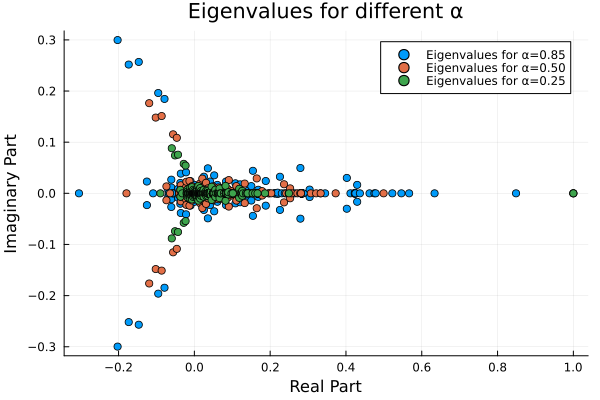

In [9]:
λ_one,vectors_one=eigen(full_google_matrix(G,0.85)')
λ_two,vectors_two=eigen(full_google_matrix(G,0.5)')
λ_three,vectors_three=eigen(full_google_matrix(G,0.25)')

real_part_one = real.(λ_one)
imag_part_one = imag.(λ_one)

real_part_two = real.(λ_two)
imag_part_two = imag.(λ_two)

real_part_three = real.(λ_three)
imag_part_three = imag.(λ_three)

scatter(real_part_one, imag_part_one, xlabel="Real Part", ylabel="Imaginary Part", label="Eigenvalues for α=0.85",title="Eigenvalues for different α")
scatter!(real_part_two, imag_part_two, xlabel="Real Part", ylabel="Imaginary Part", label="Eigenvalues for α=0.50")
scatter!(real_part_three, imag_part_three, xlabel="Real Part", ylabel="Imaginary Part", label="Eigenvalues for α=0.25")


We want our dominant eigenvector to look like a probability distribution, thus we normalize with the L1 norm of the vector.

In [10]:
x_one=zeros(500)
x_two=zeros(500)
x_three=zeros(500)

for i in 1:length(λ_one)
    if abs(λ_one[i]-1)<10^(-6)
        x_one=real(vectors_one[:,i]/norm(vectors_one[:,i],1))
    end
end

for i in 1:length(λ_two)
    if abs(λ_two[i]-1)<10^(-6)
        x_two=real(vectors_two[:,i]/norm(vectors_two[:,i],1))
    end
end

for i in 1:length(λ_three)
    if abs(λ_one[i]-1)<10^(-6)
        x_three=real(vectors_three[:,i]/norm(vectors_three[:,i],1))
    end
end
e=ones(500)
print(e'*x_one," ",e'*x_two," ",e'*x_three)

1.0000000000000024 1.0000000000000002 1.0000000000000013

Let's now print the 10 most "important" websites in our matrix. As we can see we get different results while experimenting with α, this is due to the fact that α representes the probability of a search engine user "randomly" selecting a webpage.

In [11]:
perm_one = sortperm(x_one, rev=true)
sorted_probabilities_one = x_one[perm_one]

original_positions_one = perm_one

println("Sorted probabilities for α=0.85: ", sorted_probabilities_one[1:10])
println("Websites: ", original_positions_one[1:10])
println("")

perm_two = sortperm(x_two, rev=true)
sorted_probabilities_two = x_two[perm_two]

original_positions_two = perm_two

println("Sorted probabilities for α=0.50: ", sorted_probabilities_two[1:10])
println("Websites: ", original_positions_two[1:10])
println("")

perm_three = sortperm(x_three, rev=true)
sorted_probabilities_three = x_three[perm_three]

original_positions_three = perm_three

println("Sorted probabilities for α=0.25: ", sorted_probabilities_three[1:10])
println("Websites: ", original_positions_three[1:10])

Sorted probabilities for α=0.85: [0.050743868185011254, 0.028434335450914353, 0.02815235789867683, 0.027030484039230127, 0.02070235464106789, 0.014367392283152397, 0.014264661970466917, 0.013617114553346457, 0.013005396134865586, 0.012405812079070062]
Websites: [6, 2, 27, 20, 19, 167, 189, 145, 15, 203]

Sorted probabilities for α=0.50: [0.025654133274553452, 0.021681635273923645, 0.015956511701810776, 0.015872590489800036, 0.014750573039501608, 0.010144634705122885, 0.009493454608025849, 0.008866520835800876, 0.008745311465405076, 0.007664518894250148]
Websites: [6, 20, 19, 27, 2, 391, 15, 167, 145, 51]

Sorted probabilities for α=0.25: [0.012479558210575548, 0.012053917937360915, 0.00960748762878051, 0.008858179634034498, 0.007409980020714512, 0.007050076907741558, 0.006127468342962883, 0.0054744509550042324, 0.005250456020421351, 0.004941327314585087]
Websites: [20, 6, 19, 27, 2, 391, 15, 145, 167, 51]


## Power Iteration Algorithm

We now create the power iteration algorithm. The idea is that if we compute $x_{k+1}=G^{k}x_{k}$ the algorithm is going to converge at the dominant eigenvector. For numerical stability and complexity, we "brake" this multiplication into 1 sparse matrix-vector multiplication, and a dot product. Additionally, at every step of the algorithm we normalize with the L1 norm.

In [12]:
function power_iteration_method(g::Google, alpha::Float64)
    n = g.n
    x_old = rand(n)
    x_new = rand(n)
    x_old /= norm(x_old, 1)
    counter = 1
    errors=[]
    push!(errors,norm(x_new - x_old, 1))
    while (errors[counter]> 1e-6)
        x_old = x_new
        y = alpha * (g.adjency_matrix'*x_old)
        s = ((1 - alpha) / n) *e'* x_old
        z = s * g.e
        x_new = y + z
        x_new /= norm(x_new, 1)
        push!(errors,norm(x_new - x_old, 1))
        counter += 1
    end
    return x_new, counter , errors
end

power_iteration_method (generic function with 1 method)

## Dominant Eigenvector using the Power Iteration Method

As we can see below, we obtained the same results as with the eigendecomposition.

Sorted probabilities for α=0.85: [0.05074405041415307, 0.02843443545224881, 0.028152459954355818, 0.027030547746446018, 0.020702409544355864, 0.014367439696629052, 0.014264716266455323, 0.013617160674567166, 0.01300543623680519, 0.01240585680619966]
Websites: [6, 2, 27, 20, 19, 167, 189, 145, 15, 203]

The algorithm converged after: 51 iterations


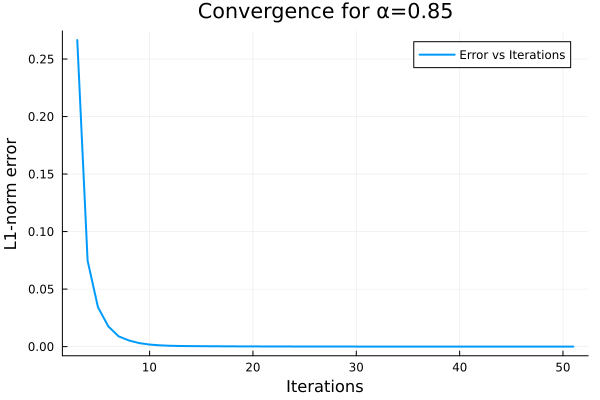

In [13]:
eigenvector,iterations,error=power_iteration_method(G, 0.85)
perm_one = sortperm(eigenvector, rev=true)
sorted_probabilities_one = eigenvector[perm_one]

original_positions_one = perm_one

println("Sorted probabilities for α=0.85: ", sorted_probabilities_one[1:10])
println("Websites: ", original_positions_one[1:10])
println("")
println("The algorithm converged after: ",iterations," iterations")

plot(3:iterations,error[3:end],xlabel="Iterations",ylabel="L1-norm error",linewidth=2, label="Error vs Iterations",title="Convergence for α=0.85")

Sorted probabilities for α=0.50: [0.025654154933769942, 0.021681652166646078, 0.01595652426823724, 0.0158725965537806, 0.014750613160679802, 0.010144640305794197, 0.009493458677639375, 0.008866538298887694, 0.008745315973480303, 0.007664522883680062]
Websites: [6, 20, 19, 27, 2, 391, 15, 167, 145, 51]



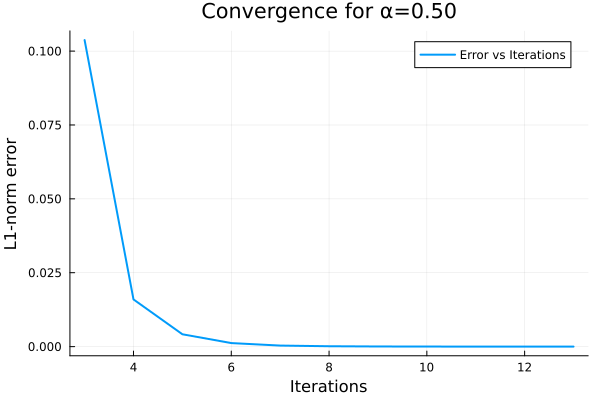

In [14]:
eigenvector,iterations,error=power_iteration_method(G, 0.5)
perm_one = sortperm(eigenvector, rev=true)
sorted_probabilities_one = eigenvector[perm_one]

original_positions_one = perm_one

println("Sorted probabilities for α=0.50: ", sorted_probabilities_one[1:10])
println("Websites: ", original_positions_one[1:10])
println("")
plot(3:iterations,error[3:end],xlabel="Iterations",ylabel="L1-norm error",linewidth=2, label="Error vs Iterations",title="Convergence for α=0.50")

Sorted probabilities for α=0.25: [0.012479558863448937, 0.012053916012390293, 0.009607488128796655, 0.008858176501980708, 0.007409988722763003, 0.007050077228840773, 0.0061274676992054845, 0.005474450191146883, 0.005250459706880358, 0.0049413267697804636]
Websites: [20, 6, 19, 27, 2, 391, 15, 145, 167, 51]



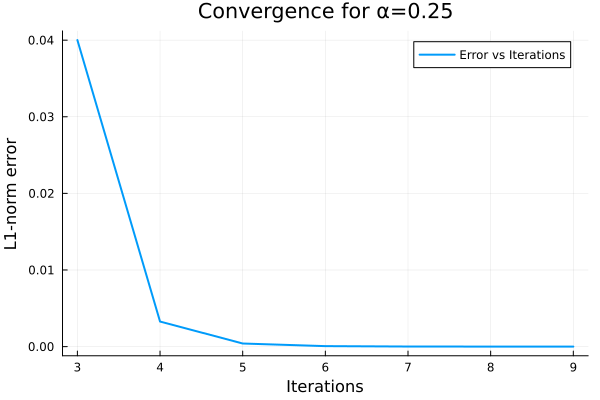

In [15]:
eigenvector,iterations,error=power_iteration_method(G, 0.25)
perm_one = sortperm(eigenvector, rev=true)
sorted_probabilities_one = eigenvector[perm_one]

original_positions_one = perm_one

println("Sorted probabilities for α=0.25: ", sorted_probabilities_one[1:10])
println("Websites: ", original_positions_one[1:10])
println("")

plot(3:iterations,error[3:end],xlabel="Iterations",ylabel="L1-norm error",linewidth=2, label="Error vs Iterations",title="Convergence for α=0.25")


## Let's try it now with a bigger matrix.

In [16]:
matfile = matopen("Purdue77587.mat")
A = sparse(read(matfile, "A"))
close(matfile)
print(size(A))

(77587, 77587)

In [17]:
A=normalize(A)
e=ones(size(A,2))
G=Google(A,e,size(A,2))

Google(sparse([175, 4, 12, 15, 65, 67, 76, 77, 80, 103  …  72279, 77584, 77585, 77586, 72279, 77316, 77317, 77319, 77586, 72279], [1, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  77585, 77585, 77585, 77585, 77586, 77586, 77586, 77586, 77586, 77587], [1.0, 0.01, 0.013333333333333332, 0.013333333333333332, 0.006666666666666666, 0.0013793103448275863, 0.02, 0.02, 0.04, 0.04  …  7.5018754688672165e-6, 0.125, 0.125, 0.125, 6.0015003750937736e-6, 0.1, 0.2, 0.06666666666666667, 0.1, 3.0007501875468866e-5], 77587, 77587), [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 77587)

In [18]:
eigenvector_one,iterations_one,error_one=power_iteration_method(G, 0.85)
perm_one = sortperm(eigenvector_one, rev=true)
sorted_probabilities_one = eigenvector_one[perm_one]

original_positions_one = perm_one

println("Sorted probabilities for α=0.85: ", sorted_probabilities_one[1:10])
println("Websites: ", original_positions_one[1:10])
println("")

Sorted probabilities for α=0.85: [0.026665214922704836, 0.026665205796613075, 0.026665204450271724, 0.02666518770219864, 0.02666516994281112, 0.02666516826715807, 0.026665152928776942, 0.026665052032012335, 0.02666500437691954, 0.026665001572987606]
Websites: [29891, 7594, 32694, 20278, 34791, 351, 38724, 3373, 35483, 32506]



In [19]:
eigenvector_two,iterations_two,error_two=power_iteration_method(G, 0.50)
perm_two = sortperm(eigenvector_two, rev=true)
sorted_probabilities_two = eigenvector_two[perm_two]

original_positions_two = perm_two

println("Sorted probabilities for α=0.50: ", sorted_probabilities_two[1:10])
println("Websites: ", original_positions_two[1:10])
println("")


Sorted probabilities for α=0.50: [0.00010865577824450723, 0.00010865567144568739, 0.00010865314568799215, 0.00010865311214517707, 0.00010865278228354044, 0.00010865155814004045, 0.00010865127421989778, 0.00010865071904388906, 0.0001086496808882084, 0.00010864675912112454]
Websites: [38697, 38046, 32693, 32695, 34791, 38724, 34788, 3373, 351, 335]



In [20]:
eigenvector_three,iterations_three,error_three=power_iteration_method(G, 0.25)
perm_three = sortperm(eigenvector_three, rev=true)
sorted_probabilities_one = eigenvector_three[perm_one]

original_positions_three = perm_three

println("Sorted probabilities for α=0.25: ", sorted_probabilities_three[1:10])
println("Websites: ", original_positions_three[1:10])
println("")

Sorted probabilities for α=0.25: [0.012479558210575548, 0.012053917937360915, 0.00960748762878051, 0.008858179634034498, 0.007409980020714512, 0.007050076907741558, 0.006127468342962883, 0.0054744509550042324, 0.005250456020421351, 0.004941327314585087]
Websites: [32693, 3373, 7677, 47533, 6088, 38723, 29540, 34791, 38716, 35483]



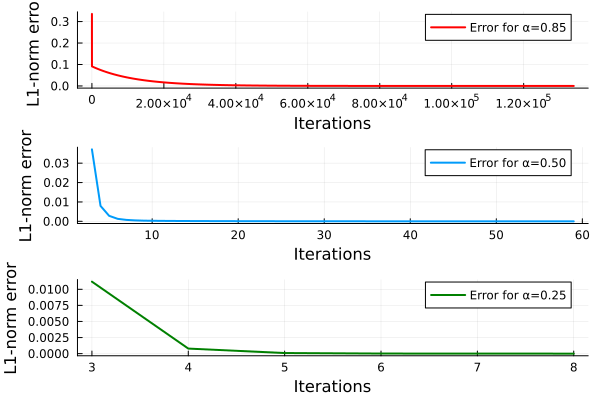

In [21]:
p1 = plot(3:iterations_one, error_one[3:end], xlabel="Iterations", ylabel="L1-norm error",
           linewidth=2, label="Error for α=0.85",color="red")
p2 = plot(3:iterations_three, error_three[3:end], xlabel="Iterations", ylabel="L1-norm error",
           linewidth=2, label="Error for α=0.25",color="green")
p3 = plot(3:iterations_two, error_two[3:end], xlabel="Iterations", ylabel="L1-norm error",
           linewidth=2, label="Error for α=0.50")

plot(p1,p3,p2,layout=(3, 1))

We check now that our eigenvectors indeed represent probabilities. 

In [22]:
println(norm(eigenvector_one,1))
println(norm(eigenvector_two,1))
println(norm(eigenvector_three,1))

1.000000000000076
1.000000000000015
0.9999999999999333


And finally we calculate the second biggest eigenvalue, based on the iterations the algorithm needed to converge. As we saw, for α=0.85 the algorithm needed $10^{5}$ iterations in order to converge, which can very well be explained by the fact that the second biggest eigenvalue is approximatelly equal to $1$.

In [23]:
λ_two_it1=(1e-6)^(1/iterations_one)
λ_two_it2=(1e-6)^(1/iterations_two)
λ_two_it3=(1e-6)^(1/iterations_three)

println("The second biggest absolute eigenvalue, for α=0.85 is: ",λ_two_it1)
println("The second biggest absolute eigenvalue, for α=0.50 is: ",λ_two_it2)
println("The second biggest absolute eigenvalue, for α=0.25 is: ",λ_two_it3)

The second biggest absolute eigenvalue, for α=0.85 is: 0.9998968359737895
The second biggest absolute eigenvalue, for α=0.50 is: 0.7912342618981322
The second biggest absolute eigenvalue, for α=0.25 is: 0.1778279410038923
